# <font color=#FF1493>Bio-Inspired Learning</font>

## <font color=#FF69B4>Travelling Salesman Optimization (TSP) via Ant Colony Optimization</font>

![Image in a markdown cell](https://miro.medium.com/v2/resize:fit:720/format:webp/1*nqbziCrKgqFwDTy7G_fLtA.png)

---
* #### This Notebooks is based on the [Travel Time Optimization via Ant Colony and Genetic Evolution](https://towardsdatascience.com/using-ant-colony-and-genetic-evolution-to-optimize-ride-sharing-trip-duration-56194215923f)

* #### GitHub [Travel Time Optimization via Ant Colony and Genetic Evolution](https://github.com/khanhnamle1994/trip-optimizer/tree/master/Bio-Inspired-Algorithms )

---
---
### <font color=#C0C0C0>Master of Science in Signal Theory and Communications (MUTSC)</font>
### *Signal processing and machine learning for big data*
## <font color=orange>ETSIT - UPM</font>
---

#### Install [*Haversine*](https://pypi.org/project/haversine/)

> Calculate the distance (in various units) between two points on Earth using their latitude and longitude

In [32]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd

In [34]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import numpy as np
from haversine import haversine, Unit
import random, sys, time, math
from multiprocessing import Pool

from shapely.geometry import Point
import geopandas
from geopandas import GeoDataFrame


%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')


## Data

> In data.csv, we have 27 drop-point in which all data belong to cluster 0, and each data has information about latitude and longitude. tracking_id is the unique id for each row of data.

In [36]:
df = pd.DataFrame(
    {'City': ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'],
     'Country': ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Venezuela'],
     'Latitude': [-34.58, -15.78, -33.45, 4.60, 10.48],
     'Longitude': [-58.66, -47.91, -70.66, -74.08, -66.86]})

In [37]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [38]:
print(gdf.head())

           City    Country  Latitude  Longitude                     geometry
0  Buenos Aires  Argentina    -34.58     -58.66  POINT (-58.66000 -34.58000)
1      Brasilia     Brazil    -15.78     -47.91  POINT (-47.91000 -15.78000)
2      Santiago      Chile    -33.45     -70.66  POINT (-70.66000 -33.45000)
3        Bogota   Colombia      4.60     -74.08    POINT (-74.08000 4.60000)
4       Caracas  Venezuela     10.48     -66.86   POINT (-66.86000 10.48000)


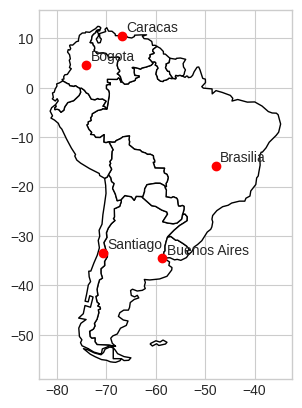

In [39]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.City):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

plt.show()

In [ ]:
len(df)

5

In [40]:
df.head()

,City,Country,Latitude,Longitude,geometry
0,Buenos Aires,Argentina,-34.58,-58.66,POINT (-58.66000 -34.58000)
1,Brasilia,Brazil,-15.78,-47.91,POINT (-47.91000 -15.78000)
2,Santiago,Chile,-33.45,-70.66,POINT (-70.66000 -33.45000)
3,Bogota,Colombia,4.60,-74.08,POINT (-74.08000 4.60000)
4,Caracas,Venezuela,10.48,-66.86,POINT (-66.86000 10.48000)


## Distance matrix

> Prepare the distance matrix from our latitude and longitude of data.

We use haversine to get distance among the geo-location. We set the result in unit meter, but later we divide it by 1000 convert it into unit km. So, our result will show in km.

https://github.com/ppoffice/ant-colony-tsp/blob/master/aco.py


In [41]:
# construct the distance matrix based on haversine
from haversine import haversine, Unit

distance = []
for i in range(len(df)):
    lat = df.iloc[i]['Latitude']
    lng = df.iloc[i]['Longitude']
    from_node = (lng, lat)
    result = []
    for j in range(len(df)):
        lat = df.iloc[j]['Latitude']
        lng = df.iloc[j]['Longitude']
        to_node = (lng, lat)
        dist = round(haversine(from_node, to_node,
                unit=Unit.METERS))
        result.append(dist/1000)
    distance.append(result)
    
print(distance)

[[0.0, 1718.267, 1335.367, 2364.324, 2402.116], [1718.267, 0.0, 2697.011, 3072.05, 2588.097], [1335.367, 2697.011, 0.0, 1310.67, 1776.256], [2364.324, 3072.05, 1310.67, 0.0, 831.083], [2402.116, 2588.097, 1776.256, 831.083, 0.0]]


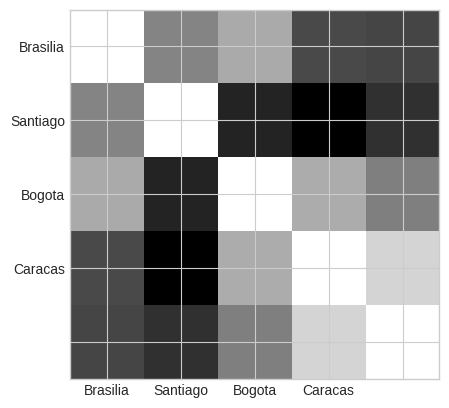

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.gca()
ax.imshow(distance)

ax.set_xticklabels(['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'])
ax.set_yticklabels(['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas'])

plt.show()

* ### Graph initialized with matrix of cities distances and initial pheromones

> = 1/ num_cities^2 = 1/ (rank^rank)

In [43]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank)
                           for j in range(rank)] for i in range(rank)]

In [44]:
test_graph = Graph(distance, len(df))

In [45]:
test_graph.pheromone[0][0:4]

[0.04, 0.04, 0.04, 0.04]

In [ ]:
1/(5*5)

0.04

In [46]:
test_graph.matrix[0][0:4]

[0.0, 1718.267, 1335.367, 2364.324]


## The ACO class

*     After each ant generates their corresponding solution, the pheromone matrix is updated.

*     How this is done depends on the strategy employed. In this solution, I update each pheromone edge by first multiplying it by p (the residual coefficient). This represents the rate at which the pheromones “evaporate” or decrease their influence.

*      We then add to the pheromone edge q/c where q represents the pheromone intensity and C represents the total cost of the generated path. 

*      Because the travel time cost is in the denominator, paths with greater travel times will have a lower probability of being picked. This process is repeated for g number of times, where g represents the number of generation

### Note that the original blog includes info on "travel time"

> I will have my pheromone quality tau equivalent to lower travel times. 
> Each edge in the complete graph will have a corresponding inverse travel time cost eta and pheromone tau.

In [47]:
class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph, verbose: bool = False):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))
            if verbose:
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    gen+1, best_cost, avg_costs[-1], best_solution))
        return best_solution, best_cost, avg_costs, best_costs


### The ANT Class

In [48]:
class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        self.allowed = [i for i in range(graph.rank)]  # nodes which are allowed for the next selection
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                                                                                            i] ** self.colony.beta
        # noinspection PyUnusedLocal
        probabilities = [0 for i in range(self.graph.rank)]  # probabilities for moving to a node in the next step
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [[0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [49]:
aco = ACO(10, 100, 1.0, 10.0, 0.5, 10, 2)
graph = Graph(distance, len(df))

In [50]:
graph.rank

5

# Create ants

In [76]:
ant_object = _Ant(aco,graph)

In [81]:
ant_count = 5

ants = [ant_object for i in range(ant_count)]

In [82]:
# Get results from ant colony, specify whether verbose output
best_solution, best_cost, avg_costs, best_cost = aco.solve(graph, True)

Generation #1 best cost: 7783.484, avg cost: 7783.484, path: [4, 3, 2, 0, 1]
Generation #2 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #3 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #4 best cost: 7783.4839999999995, avg cost: 8733.023000000001, path: [2, 0, 1, 4, 3]
Generation #5 best cost: 7783.4839999999995, avg cost: 8733.023, path: [2, 0, 1, 4, 3]
Generation #6 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #7 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #8 best cost: 7783.4839999999995, avg cost: 8733.023000000001, path: [2, 0, 1, 4, 3]
Generation #9 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #10 best cost: 7783.4839999999995, avg cost: 8733.023000000001, path: [2, 0, 1, 4, 3]
Generation #11 best cost: 7783.4839999999995, avg cost: 7783.484, path: [2, 0, 1, 4, 3]
Generation #12 best cost

In [83]:
best_solution

[2, 0, 1, 4, 3]

In [84]:
capitals = ['Buenos Aires', 'Brasilia', 'Santiago', 'Bogota', 'Caracas']

for i in best_solution:
  print(capitals[i])

Santiago
Buenos Aires
Brasilia
Caracas
Bogota


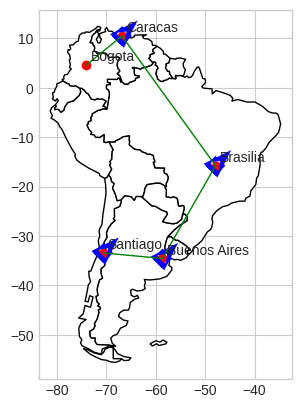

Santiago
Buenos Aires
Brasilia
Caracas
Bogota


In [85]:
# We restrict to South America.
ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.City):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")


for i in range(len(best_solution)-1):
  ior   = best_solution[i]
  idest = best_solution[i+1]
  y_values = [ df.iloc[ior].Latitude, df.iloc[idest].Latitude]
  x_values = [ df.iloc[ior].Longitude, df.iloc[idest].Longitude]

  plt.plot(x_values, y_values, linewidth = 1, linestyle = "-", color = "green")

  plt.arrow(x_values[0], y_values[0], 0.01, 0.01, shape='full', lw=10,
   length_includes_head=True, head_width=.02, color='b')

plt.show()

for i in best_solution:
  print(capitals[i])